

*Objective of this challenge*
> "In this challenge, your task is to develop a binary clasification model to identify faulty sensors, regardless of the device type. The model will be used to automatically flag devices that have faulty readings."



## 1. Importing libraries


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 2. Loading data

In [ ]:
# Load files
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [ ]:
# Preview test dataset
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000


In [ ]:
# Preview sample submission file
samplesubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [ ]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((297177, 7), (127361, 6), (127361, 2))

## 3. Statistical summaries

In [ ]:
# Train statistical summary
train.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2021-11-26 17:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.75120,38.18302,23.31655,78.65362,0.37107
std,NaN,NaN,28.52618,28.64776,3.83697,14.77272,0.48309
min,NaN,NaN,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,NaN,NaN,22.43000,19.52000,20.40000,68.00000,0.00000


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*

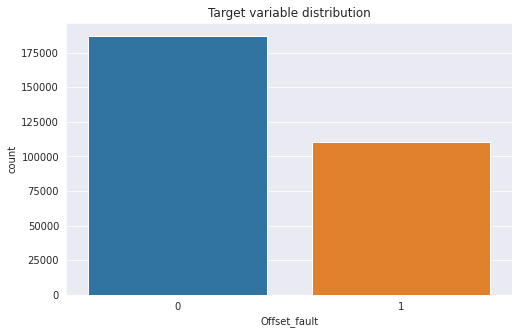

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

## 4. Data Cleaning

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

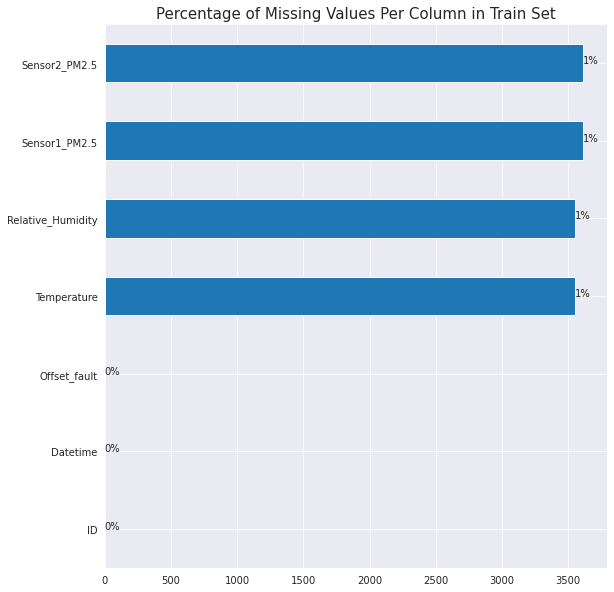

In [ ]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
# Fill missing values with zeros
train = train.fillna(0)

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplictes 

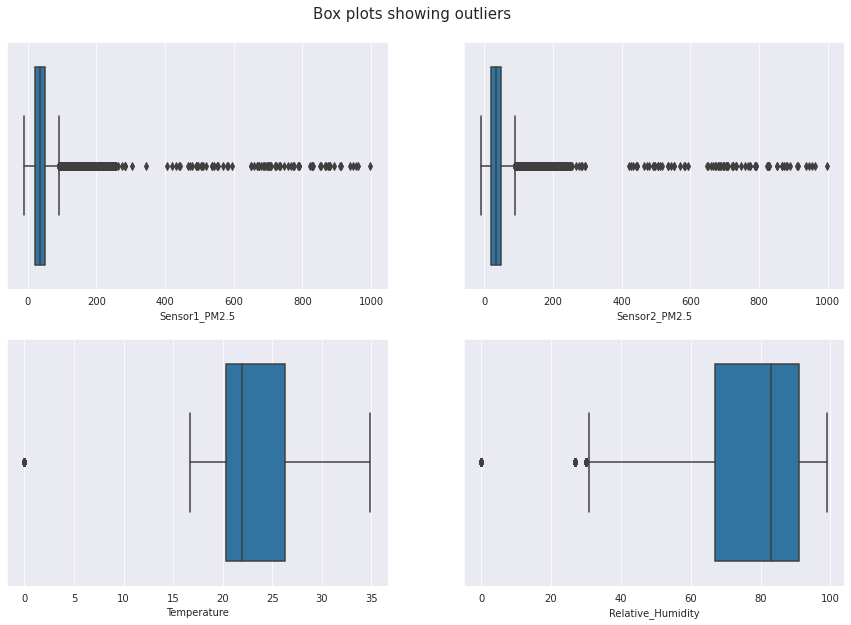

In [ ]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(train[name], ax = ax)

## 5. Feature engineering

In [ ]:
# Extract day, month year and hour from the Datetime column
# day
train['Datetime_day'] = train.Datetime.dt.day

# month
train['Datetime_month'] = train.Datetime.dt.month
 
# year
train['Datetime_year'] = train.Datetime.dt.year

# hour
train['Datetime_hour'] = train.Datetime.dt.hour

# Preview engineered date features
train[['Datetime', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour']].head()

,Datetime,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,2021-11-03 04:06:31,3,11,2021,4
1,2021-11-08 18:43:23,8,11,2021,18
2,2021-11-07 09:50:33,7,11,2021,9
3,2022-01-01 18:55:15,1,1,2022,18
4,2021-11-05 22:23:48,5,11,2021,22


## 6.  EDA

a) Data Features:

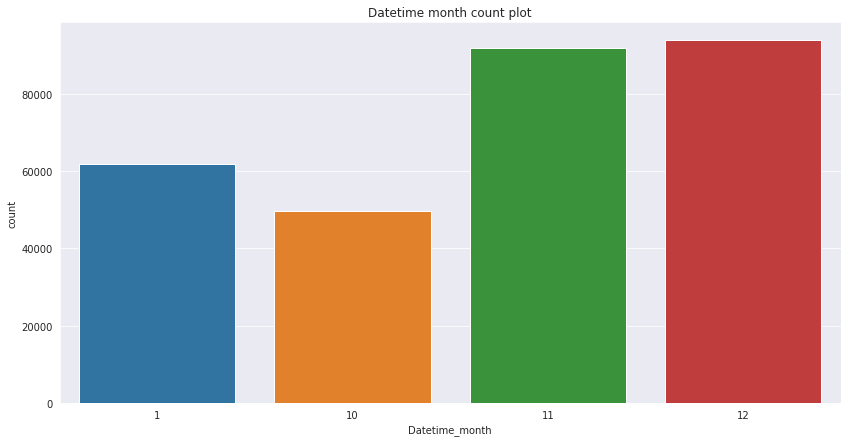

In [ ]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = train)
plt.title('Datetime month count plot')
plt.show()

- The only months available in the train set include *Jan, Oct, Nov and Dec*
- March has the least number of observations in the dataset while December has the highest number of observations

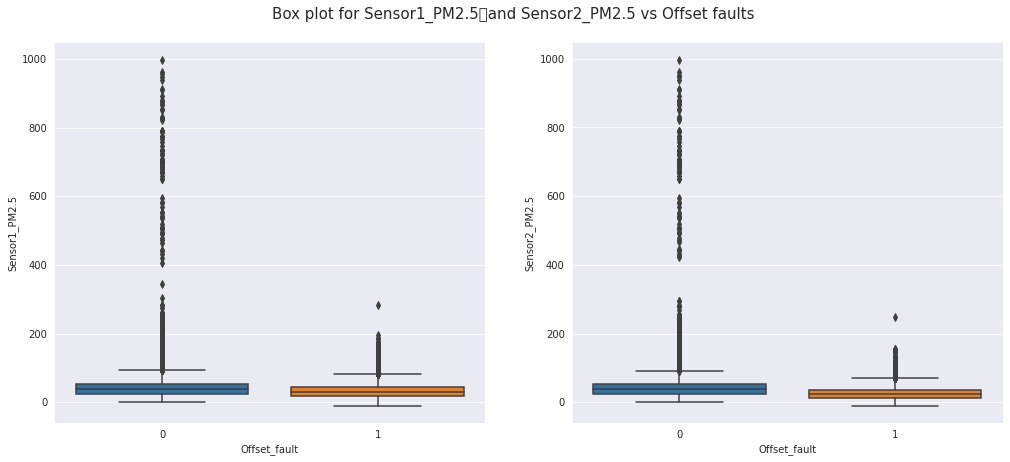

In [ ]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
  sns.boxplot(train.Offset_fault, train[name], ax= ax)

 - Sensor 1 and sensor 2 are highly correlated with majority of the non faulty observations having the highest number of outliers

b) Correlations

<Figure size 1440x864 with 0 Axes>

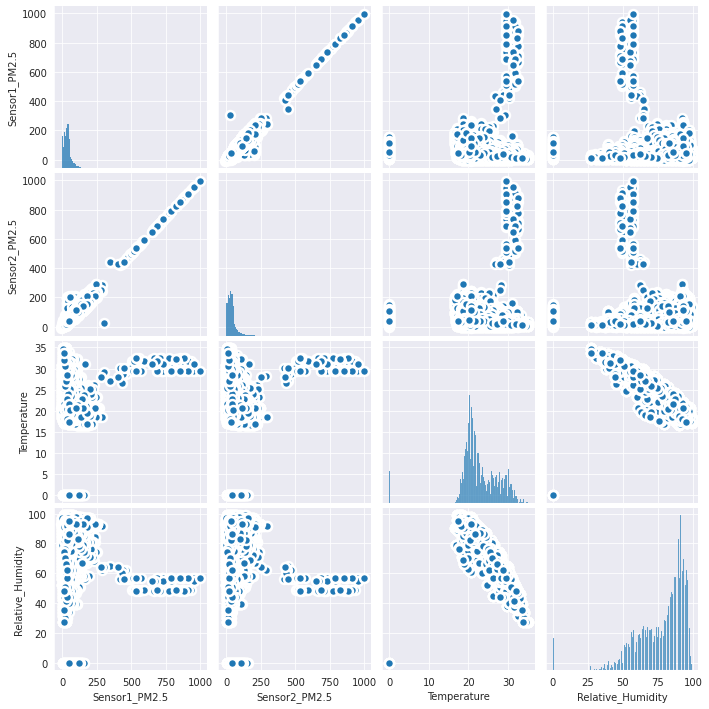

In [ ]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

 - There is a positive correlation between Sensor1_PM2.5	Sensor2_PM2.5
 - There is a negative correlation between temperature and humidity
 - There seems to be no correlation between sensor PM2.5 and temperature/humidity

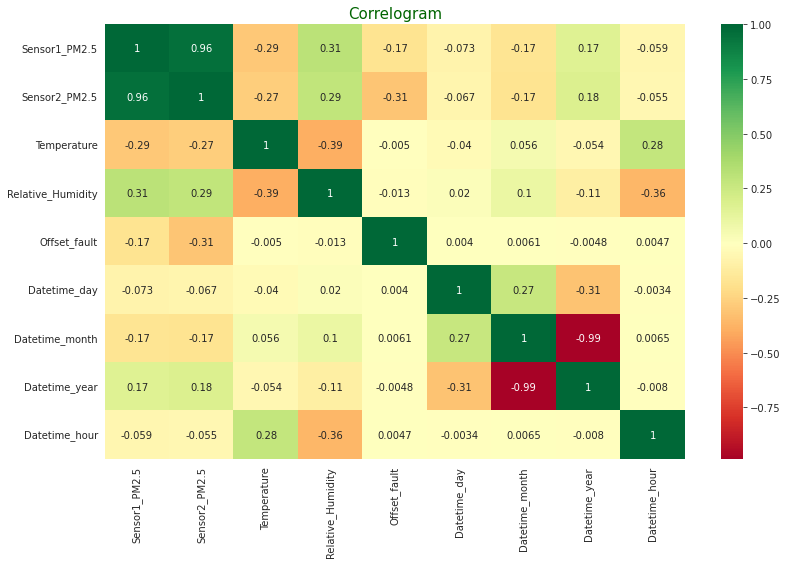

In [ ]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

- There is a 0.96 positive correlation between sensor1 PM2.5 and sensor2 PM2.5
- There is a -0.99 negative correlation between temperature and humidity

## 7.  Preprocess test dataset

In [ ]:
# Extract day, month and year from the Datetime column
test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_year'] = test.Datetime.dt.year
test['Datetime_hour'] = test.Datetime.dt.hour

# Fill in missing values with Zeroes
test = test.fillna(0)

# Preview engineered test set
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000,28,1,2022,8
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,0.00000,0.00000,16,2,2022,21
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000,24,1,2022,17
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000,31,1,2022,7
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000,31,1,2022,0


## 8.  Modelling

In [ ]:
# Selecting the independent variables and the target variable
train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',	'Datetime_day',\
               'Datetime_month',	'Datetime_year', 'Datetime_hour']

In [ ]:
X = train[train_feats].fillna(0)
y = train.Offset_fault

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

a) RandomForestClassifier

In [ ]:
# Instantiating the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.96950220965969


              precision    recall  f1-score   support

           0       0.97      0.98      0.98     55966
           1       0.96      0.96      0.96     33188

    accuracy                           0.97     89154
   macro avg       0.97      0.97      0.97     89154
weighted avg       0.97      0.97      0.97     89154



b) More Classifier Models:

In [ ]:
pip install catboost

In [ ]:
#import classifier algorithm here
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# create models
lg_model = LogisticRegression()
kn_model = KNeighborsClassifier()
et_model = ExtraTreesClassifier()
xg_model = XGBClassifier()
ctb_model = CatBoostClassifier()


#training the models
lg_model.fit(X_train,y_train)
kn_model.fit(X_train,y_train)
et_model.fit(X_train,y_train)
xg_model.fit(X_train,y_train)
ctb_model.fit(X_train,y_train)

Learning rate set to 0.100639
0:	learn: 0.6505789	total: 55.9ms	remaining: 55.8s
1:	learn: 0.6119012	total: 107ms	remaining: 53.5s
2:	learn: 0.5791467	total: 147ms	remaining: 48.9s
3:	learn: 0.5518978	total: 194ms	remaining: 48.2s
4:	learn: 0.5256973	total: 235ms	remaining: 46.7s
5:	learn: 0.5064848	total: 277ms	remaining: 45.9s
6:	learn: 0.4915383	total: 322ms	remaining: 45.7s
7:	learn: 0.4722929	total: 363ms	remaining: 45s
8:	learn: 0.4596878	total: 409ms	remaining: 45s
9:	learn: 0.4495534	total: 449ms	remaining: 44.5s
10:	learn: 0.4370272	total: 489ms	remaining: 44s
11:	learn: 0.4265867	total: 545ms	remaining: 44.9s
12:	learn: 0.4198878	total: 591ms	remaining: 44.9s
13:	learn: 0.4111301	total: 635ms	remaining: 44.7s
14:	learn: 0.4047320	total: 678ms	remaining: 44.5s
15:	learn: 0.3941826	total: 723ms	remaining: 44.5s
16:	learn: 0.3822930	total: 768ms	remaining: 44.4s
17:	learn: 0.3771817	total: 808ms	remaining: 44.1s
18:	learn: 0.3719082	total: 854ms	remaining: 44.1s
19:	learn: 0.367

In [ ]:
# Making predictions
lg_ypred = lg_model.predict(X_test)
kn_ypred = kn_model.predict(X_test)
et_ypred = et_model.predict(X_test)
xg_ypred = xg_model.predict(X_test)
ctb_ypred = ctb_model.predict(X_test)

In [ ]:
# evaluating the models:

print("Logistic Regression classifier: ", accuracy_score(y_test, lg_ypred), ('\n') ,classification_report(y_test, y_pred))
print('\n')

print("KNeighbors Classifier: ", accuracy_score(y_test, kn_ypred), ('\n') ,classification_report(y_test, y_pred))
print('\n')

print("Extra Tree classifier: ", accuracy_score(y_test, et_ypred), ('\n') ,classification_report(y_test, y_pred))
print('\n')

print("XGB classifier: ", accuracy_score(y_test, xg_ypred),('\n') ,classification_report(y_test, y_pred))
print('\n')

print("CatBoost Classifier: ", accuracy_score(y_test, ctb_ypred),('\n') ,classification_report(y_test, y_pred))

Logistic Regression classifier:  0.894340130560603 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     55966
           1       0.96      0.96      0.96     33188

    accuracy                           0.97     89154
   macro avg       0.97      0.97      0.97     89154
weighted avg       0.97      0.97      0.97     89154



KNeighbors Classifier:  0.9654754694124773 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     55966
           1       0.96      0.96      0.96     33188

    accuracy                           0.97     89154
   macro avg       0.97      0.97      0.97     89154
weighted avg       0.97      0.97      0.97     89154



Extra Tree classifier:  0.96950220965969 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     55966
           1       0.96      0.96      0.96     33188

    accuracy                         

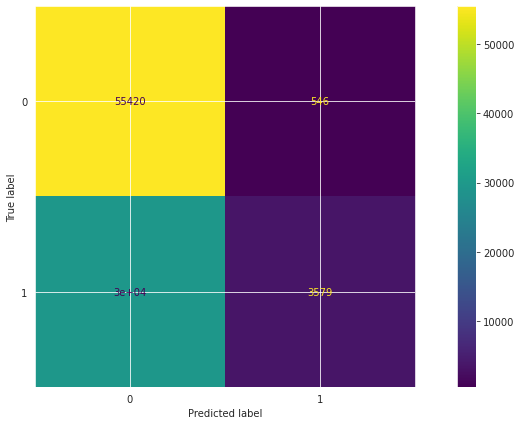

In [ ]:
#Confusion matrix for particular model:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

### Hyperparameter Tuning:

In [ ]:
from sklearn.model_selection import GridSearchCV

a) random forest

In [ ]:
for max_depth in [3, 5, 8, 10, 14, 18]:
    model = RandomForestClassifier()
    # Again, you van use a better method to evaluate the model here...
    model.fit(X_train, y_train)
    print(max_depth, accuracy_score(y_test, model.predict(X_test)))

3 0.9696031585795365
5 0.9689189492339099
8 0.9700406038988716
10 0.9696928909527335
14 0.9697153240460327
18 0.9697153240460327


b) xgbclassifer

In [ ]:
# Optimize model paramaters 
param_grid = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3,5]
        }
my_xg_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xg_model.fit(X_train, y_train)
print(my_xg_model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}


**Confirming :**

In [ ]:
# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=0.5, subsample=0.6, max_depth=5)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Get error rate
print("XGB classifier: ", accuracy_score(y_test, y_pred))

XGB classifier:  0.938477241626848


a little bit better

In [ ]:
# Fit a model on the whole training set, using our best parameters
rf_b = RandomForestClassifier(max_depth=18)
rf_b.fit(X_train, y_train)

RandomForestClassifier(max_depth=18)

#9. Making predictions of the test set and creating a submission file

In [ ]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = xgb_model.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

In [ ]:
# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

 - Majority of the model predictions are 0

In [ ]:
# Create file
sub_file.to_csv('xgb_b.csv', index = False)

My best submission in the zindi leaderboard was with:

*xgb classsifier with the tuned hyperparameters*